In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats

In [2]:
# 한글폰트 사용 in colab
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [3]:
from google.colab import files
uploaded = files.upload()

Saving vgames2.csv to vgames2 (1).csv


In [4]:
vgames2_unclean = pd.read_csv('vgames2.csv')

In [5]:
vgames2_unclean.drop(['Unnamed: 0'], axis = 1, inplace = True)
df = vgames2_unclean.copy()

##1. 시각적 탐색

In [6]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


year : 데이터 타입이 integer이어야 하지만 소수점을 가진 float으로 확인된다. <br>
NA_Sales / EU_Sales / JP_Sales / Other_Sales 
: 연간 출고량을 나타내는 데이터 값이  소수점을 가진 float으로 확인된다. <br>


##2. 프로그래매틱 탐색 및 데이터 정제

In [7]:
df.shape

(16598, 9)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


In [9]:
df.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

###a. 결측치 확인
year, Genre, Publisher 컬럼값에 결측치가 존재함을 확인. <br>
각 변수별 결측치의 비율을 구해본 결과 전체 데이터의 2% 미만이므로 삭제하도록 한다.<br>

In [10]:
#결측치 비율 확인하기 
df.isnull().sum() / len(df) * 100

Name           0.000000
Platform       0.000000
Year           1.632727
Genre          0.301241
Publisher      0.349440
NA_Sales       0.000000
EU_Sales       0.000000
JP_Sales       0.000000
Other_Sales    0.000000
dtype: float64

In [11]:
df.dropna(axis = 0, inplace = True)

In [12]:
df.shape

(16241, 9)

###b. 중복값 확인 

In [13]:
df.duplicated().sum()

0

###C. 오류 데이터 수정

#####1) Year

In [14]:
df['Year'] = df['Year'].astype('int')

In [15]:
df['Year'].describe()

count    16241.000000
mean      1994.178437
std        155.484265
min          0.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2020.000000
Name: Year, dtype: float64

In [16]:
df['Year'].unique()  # yyyy 형태가 아닌 데이터 발견 

array([2008, 2009, 2010, 2005, 2011, 2007, 2001, 2003, 2006, 2014, 2015,
       2002, 1997, 2013, 1996, 2004, 2000, 1984, 1998, 2016, 1985, 1999,
          9,   97, 1995, 1993, 2012, 1987, 1982,   11, 1994, 1990,   15,
       1992, 1991, 1983, 1988, 1981,    3, 1989,   96,    6,    8, 1986,
          1,    5,    4,   10,   98,    7,   16,   86,   14,   95, 2017,
       1980, 2020,    2,   13,    0,   12,   94])

In [17]:
df = df.drop(index = df[df['Year'] <= 9].index)  #0~9 삭제 
df[df['Year'] <= 9]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales


In [18]:
df = df.drop(index = df[df['Year'] <= 9].index)  #0~9 삭제 

convert = df['Year']
def convert(x):   # yyyy으로 변경 
  if x <= 20:
    x = 2000 + x
  elif x <= 99:
    x = 1900 + x
  return x
df['Year'] = df['Year'].apply(convert)

In [19]:
df['Year'] = df['Year'].astype('int')

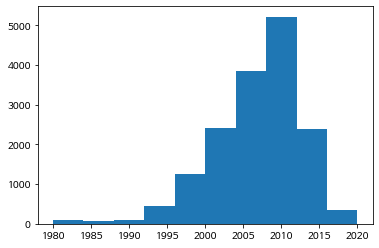

In [20]:
plt.hist(df['Year']);

#####2) Sales

In [21]:
# NA_Sales에 섞여 있는 오류 데이터를 확인
import re
def has_errors(inputstr):
  return bool(re.search('[a-zA-Z]', inputstr))
  
error_condition_1 =df.NA_Sales.apply(has_errors)
error_NA = df[error_condition_1]
error_NA

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
10,Ford Racing,PS,2001,Racing,Empire Interactive,480K,0.33M,0K,0.06
45,Resident Evil: Revelations 2,PS3,2015,Action,Capcom,60K,0.08,0.16,0.03
145,TOCA Race Driver 3,PC,2006,Racing,Codemasters,0K,0.02,0,0
447,Medal of Honor: Warfighter,X360,2012,Action,Electronic Arts,0.58M,0.47,0.01,0.1
458,F1 2010,PS3,2010,Racing,Codemasters,0.25M,0.76,0.08,0.27
...,...,...,...,...,...,...,...,...,...
16330,Midway Arcade Treasures,PS2,2003,Misc,Midway Games,720K,0.56,0,0.19
16408,NASCAR 06: Total Team Control,PS2,2005,Racing,Electronic Arts,0.53M,0.02,0,0.09
16482,Super Robot Taisen F Kanketsuhen,SAT,1998,Strategy,Banpresto,0M,0,0.55,0
16492,Mortal Kombat,PSV,2012,Fighting,Warner Bros. Interactive Entertainment,470K,0.18,0,0.12


In [22]:
error_Sales = df.iloc[:, 5:]
error_Sales.dtypes

NA_Sales       object
EU_Sales       object
JP_Sales       object
Other_Sales    object
dtype: object

In [23]:
#출고량과 관련있는 컬럼의  M, K 처리
#M은 float형 데이터에, K는 int형 데이터에 붙어있음

def error_Sales(x):
  if 'K' in x:
    x = x[:len(x)-1]
    x = float(x) * 1000
  elif 'M' in x:
    x = x[:len(x)-1]
    x = float(x) * 1000000
  else:
    x = float(x) * 1000000
  return x

for i in ['NA_Sales', 'EU_Sales',	'JP_Sales', 'Other_Sales']:
  df[i] = df[i].apply(error_Sales)

In [24]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,40000.0,0.0,0.0,0.0
1,The Munchables,Wii,2009,Action,Namco Bandai Games,170000.0,0.0,0.0,10000.0
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.0,0.0,20000.0,0.0
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,40000.0,0.0,0.0,0.0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,120000.0,90000.0,0.0,40000.0


###e. 이상치 판단하기

#####**1) NA_Sales**

In [25]:
df['NA_Sales'].describe()

count    1.618800e+04
mean     2.654689e+05
std      8.235275e+05
min      0.000000e+00
25%      0.000000e+00
50%      8.000000e+04
75%      2.400000e+05
max      4.149000e+07
Name: NA_Sales, dtype: float64

In [26]:
df[df['NA_Sales'] == 41490000.0]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
2908,Wii Sports,Wii,2006,Sports,Nintendo,41490000.0,29020000.0,3770000.0,8460000.0


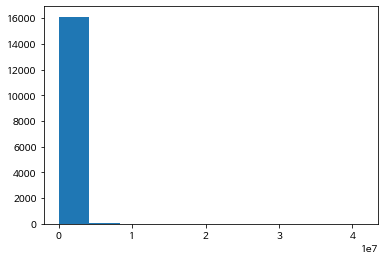

In [27]:
plt.hist(df.NA_Sales);

#####**2) EU_Sales**

In [28]:
df['EU_Sales'].describe()

count    1.618800e+04
mean     1.475717e+05
std      5.090670e+05
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+04
75%      1.100000e+05
max      2.902000e+07
Name: EU_Sales, dtype: float64

In [29]:
df[df['EU_Sales'] == 29020000.0]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
2908,Wii Sports,Wii,2006,Sports,Nintendo,41490000.0,29020000.0,3770000.0,8460000.0


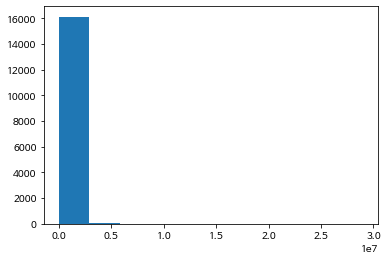

In [30]:
plt.hist(df.EU_Sales);

#####**3**) JP_Sales 

In [31]:
df['JP_Sales'].describe()

count    1.618800e+04
mean     7.847047e+04
std      3.097405e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.000000e+04
max      1.022000e+07
Name: JP_Sales, dtype: float64

In [32]:
df[df['JP_Sales'] == 10220000.0]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
7829,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11270000.0,8890000.0,10220000.0,1000000.0


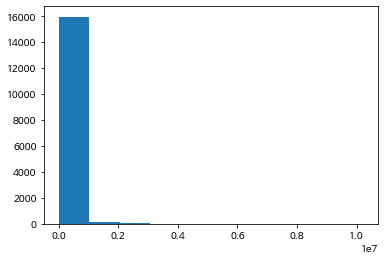

In [33]:
plt.hist(df['JP_Sales']);

#####4) Other_Sales

In [34]:
df['Other_Sales'].describe()

count    1.618800e+04
mean     4.829689e+04
std      1.899597e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+04
75%      4.000000e+04
max      1.057000e+07
Name: Other_Sales, dtype: float64

In [35]:
df[df['Other_Sales'] ==10570000.0]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
14669,Grand Theft Auto: San Andreas,PS2,2004,Action,Take-Two Interactive,9430000.0,400000.0,410000.0,10570000.0


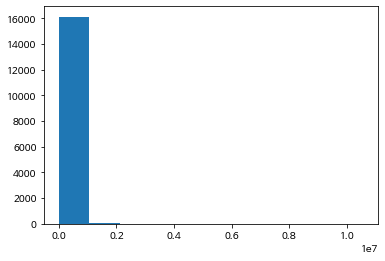

In [36]:
plt.hist(df['Other_Sales']);

#####시사점
EDA에서 출고량이 높은 게임에 대한 분석을 진행 할 예정이기 때문에 outlier라고 판단되는 값을 제거하지 않는다.

###f. 데이터 타입 변경하기

In [37]:
df = df.astype({'NA_Sales':'int', 'EU_Sales':'int', 'JP_Sales':'int', 'Other_Sales':'int'})
df.dtypes

Name           object
Platform       object
Year            int64
Genre          object
Publisher      object
NA_Sales        int64
EU_Sales        int64
JP_Sales        int64
Other_Sales     int64
dtype: object

In [38]:
# df.to_excel('C:\Users\wlstj\dataframe\game.xlsx')

##3. EDA

In [39]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,40000,0,0,0
1,The Munchables,Wii,2009,Action,Namco Bandai Games,170000,0,0,10000
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0,0,20000,0
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,40000,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,120000,90000,0,40000


In [40]:
df['Name'].unique(), len(df['Name'].unique())

(array(["Candace Kane's Candy Factory", 'The Munchables',
        'Otome wa Oanesama Boku ni Koi Shiteru Portable', ...,
        'White Album: Tsuzurareru Fuyu no Omoide', 'Minna no Chizu 2',
        'Rainbow Islands: Revolution'], dtype=object), 11267)

In [41]:
a = df['Year'].sort_values(ascending = True)

In [42]:
a.unique(), len(a.unique())

(array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
        1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
        2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017, 2020]), 39)

In [43]:
df['Platform'].unique(), len(df['Platform'].unique())

(array(['DS', 'Wii', 'PSP', 'PS3', 'PC', 'PS', 'GBA', 'PS4', 'PS2', 'XB',
        'X360', 'GC', '3DS', '2600', 'SAT', 'GB', 'NES', 'DC', 'N64',
        'XOne', 'SNES', 'WiiU', 'PSV', 'GEN', 'SCD', 'WS', 'NG', 'TG16',
        '3DO', 'GG', 'PCFX'], dtype=object), 31)

In [44]:
df['Genre'].unique(), len(df['Genre'].unique())

(array(['Action', 'Adventure', 'Misc', 'Platform', 'Sports', 'Simulation',
        'Racing', 'Role-Playing', 'Puzzle', 'Strategy', 'Fighting',
        'Shooter'], dtype=object), 12)

지난 1980년부터 2020년까지(2018년, 2019년 제외) 세계에서 판매된 11144개의 게임을 대상으로 분석을 시행한다. <br>
게임 플랫폼은 31개이며 장르는 12개이다.

####a. 연도별 총 판매량

In [45]:
df['total'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,total
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,40000,0,0,0,40000
1,The Munchables,Wii,2009,Action,Namco Bandai Games,170000,0,0,10000,180000
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0,0,20000,0,20000
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,40000,0,0,0,40000
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,120000,90000,0,40000,250000


In [46]:
year_total = df.groupby('Year')['total'].sum().reset_index()
year_total.head()

,Year,total
0,1980,10880000
1,1981,35680000
2,1982,28880000
3,1983,16800000
4,1984,50350000


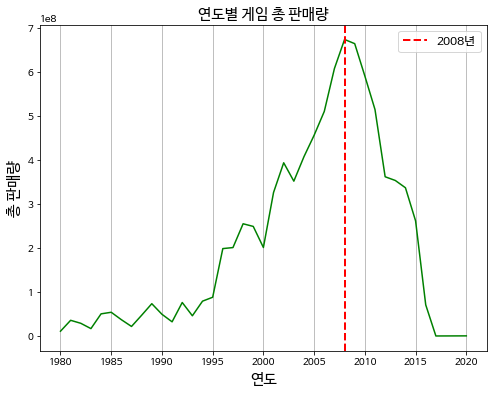

In [47]:
plt.figure(figsize = (8,6))
plt.plot( year_total['Year'], year_total['total'], color = 'Green', marker = '', linestyle = 'solid')
plt.xlabel('연도', fontsize = 15)
plt.ylabel('총 판매량', fontsize = 15)
plt.title('연도별 게임 총 판매량', fontsize =15)
plt.axvline(2008, 0, 1, color='red', linestyle='--', linewidth=2, label = '2008년')
plt.grid(axis='x')
plt.legend(fontsize = 12)
plt.show();

#####시사점 <br>
연도별 게임 총 판매량을 살펴보니 2008년 이후 판매량이 지속 감소함을 알 수 있다. <br>
이는 2008년 이후 게임 시장의 다변화로 비디오 게임 시장의 위축 가능성으로 예상할 수 있다. 

####b. 지역별 장르 선호도 파악

In [48]:
Sales = pd.DataFrame(round(df.groupby('Genre').mean())).iloc[:,1:]
Sales = Sales.reset_index()

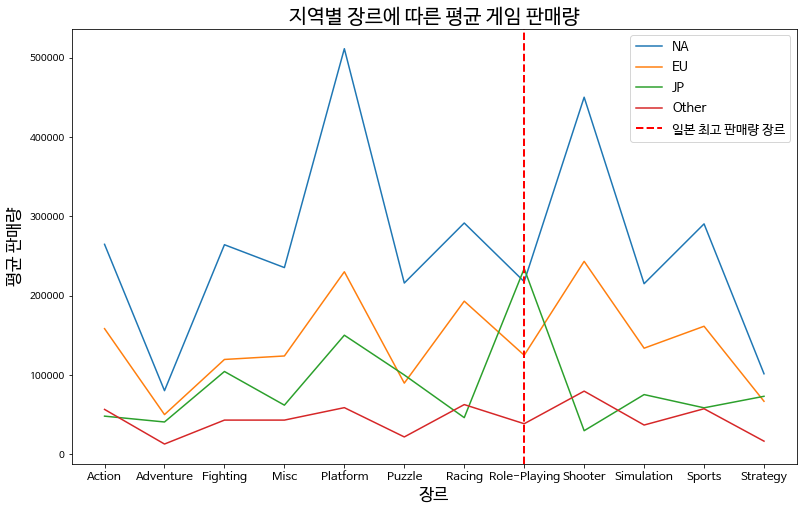

In [49]:
plt.figure(figsize = (13,8))
plt.plot( Sales['Genre'], Sales['NA_Sales'], marker = '', linestyle = 'solid', label = 'NA')
plt.plot( Sales['Genre'], Sales['EU_Sales'], marker = '', linestyle = 'solid', label = 'EU')
plt.plot( Sales['Genre'], Sales['JP_Sales'], marker = '', linestyle = 'solid', label = 'JP')
plt.plot( Sales['Genre'], Sales['Other_Sales'], marker = '', linestyle = 'solid', label = 'Other')

plt.xlabel('장르', fontsize = 17)
plt.ylabel('평균 판매량', fontsize = 17)
plt.title('지역별 장르에 따른 평균 게임 판매량', fontsize =20)
plt.xticks(fontsize = 12)
plt.axvline('Role-Playing', 0, 1, color='red', linestyle='--', linewidth=2, label = '일본 최고 판매량 장르')
plt.legend(fontsize = 13)
plt.show()

In [50]:
NA = pd.DataFrame(round(df.groupby('Genre')['NA_Sales'].mean()))
NA = NA.sort_values('NA_Sales', ascending = True).reset_index()

In [51]:
EU = pd.DataFrame(round(df.groupby('Genre')['EU_Sales'].mean()))
EU = EU.sort_values('EU_Sales', ascending = True).reset_index()

In [52]:
JP = pd.DataFrame(round(df.groupby('Genre')['JP_Sales'].mean()))
JP = JP.sort_values('JP_Sales', ascending = True).reset_index()

In [53]:
Other = pd.DataFrame(round(df.groupby('Genre')['Other_Sales'].mean()))
Other = Other.sort_values('Other_Sales', ascending = True).reset_index()

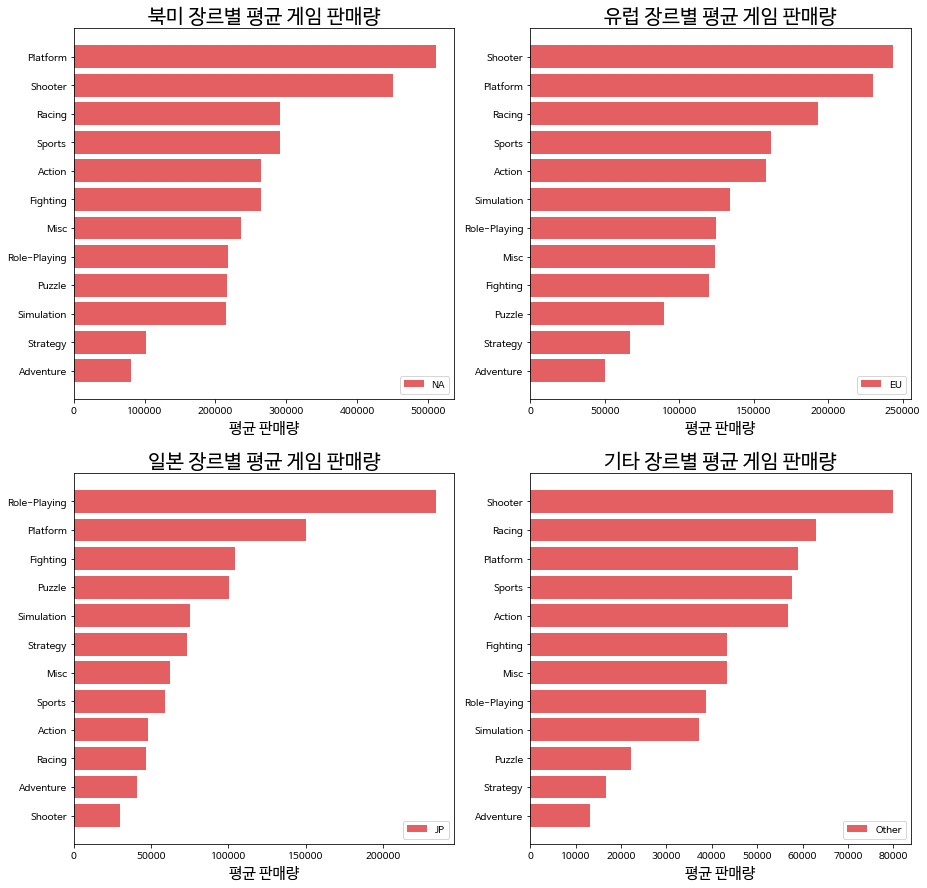

In [54]:
fig, ax = plt.subplots(2, 2, figsize = (15,15))
#북미
ax[0,0].barh(NA['Genre'], NA['NA_Sales'], label = 'NA', color='#e35f62')
ax[0,0].set_xlabel('평균 판매량', fontsize = 15)
ax[0,0].set_title('북미 장르별 평균 게임 판매량', fontsize =20)
ax[0,0].legend(fontsize = 10)

#유럽
ax[0,1].barh(EU['Genre'], EU['EU_Sales'], label = 'EU', color='#e35f62')
ax[0,1].set_xlabel('평균 판매량', fontsize = 15)
ax[0,1].set_title('유럽 장르별 평균 게임 판매량', fontsize =20)
ax[0,1].legend(fontsize = 10)


#일본
ax[1,0].barh(JP['Genre'], JP['JP_Sales'], label = 'JP', color='#e35f62')
ax[1,0].set_xlabel('평균 판매량', fontsize = 15)
ax[1,0].set_title('일본 장르별 평균 게임 판매량', fontsize =20)
ax[1,0].legend(fontsize = 10)


#기타
ax[1,1].barh(Other['Genre'], Other['Other_Sales'], label = 'Other', color='#e35f62')
ax[1,1].set_xlabel('평균 판매량', fontsize = 15)
ax[1,1].set_title('기타 장르별 평균 게임 판매량', fontsize =20)
ax[1,1].legend(fontsize = 10)

plt.show()

#####시사점<br>
지역별 게임 장르 평균 판매량을 살펴보니 북미, 유럽, 기타 지역의 판매량은 매우 유사한 패턴을 가짐을 알 수 있었다. <br>
아래 4개의 그래프는 각 지역별 평균 판매량의 순위를 살펴본 결과이다. 북미, 유럽, 기타 모두 shooter의 비율이 높은 것에 비해  <br>
일본은 shooter가 최하위에 위치하며 롤플레잉이 1위에 해당하는 것을 통해 패턴의 차이를 발견하였다.  <br>

####c. 연도별 게임의 트렌드가 있을까

연도별 판매량 1위, 2위 장르 점유율을 분석하였다.  <br>
시장점유율을 통해 신규 게임의 진입 난도를 파악, 연도별 장르 트렌드 파악 목적 <br>

In [55]:
#연도별 장르 1위 값 데이터 가져오기
year_Genre = df.groupby(['Year', 'Genre'])['total'].sum().reset_index()
max_yes = year_Genre.groupby('Year')['total'].transform(max) == year_Genre['total']
year_Genre_max = year_Genre[max_yes].reset_index(drop=True)
year_Genre_max.head()

,Year,Genre,total
0,1980,Shooter,7070000
1,1981,Action,14790000
2,1982,Puzzle,10040000
3,1983,Platform,6930000
4,1984,Shooter,31100000


In [56]:
#연도별 장르합 구하기 
Genre_sum = df.groupby(['Year'])['total'].sum().reset_index()
Genre_sum .head()

,Year,total
0,1980,10880000
1,1981,35680000
2,1982,28880000
3,1983,16800000
4,1984,50350000


In [57]:
#연도별 1위 장르의 시장 점유율 
Genre_merge_1 = pd.merge(year_Genre_max, Genre_sum, how = 'outer', on = 'Year')
Genre_merge_1['share']= round(Genre_merge_1['total_x'] / Genre_merge_1['total_y']*100, 2)
Genre_merge_1.tail()

,Year,Genre,total_x,total_y,share
34,2014,Action,99009999,337079997,29.37
35,2015,Action,68250000,261829998,26.07
36,2016,Action,19840000,70839999,28.01
37,2017,Role-Playing,40000,50000,80.00
38,2020,Simulation,290000,290000,100.00


In [58]:
#연도별 장르 2위 값을 구하기 위해 연도별 장르 1위 제외 

In [59]:
year_Genre_2 = year_Genre.drop(index = [3,   4,  14,  21,  30,  34,  39,  47,  53,  63,  68,  78,  88, 
            102, 114, 126, 141, 152, 168, 177, 192, 194, 206, 218, 230, 242,
            264, 266, 278, 300, 302, 314, 326, 338, 350, 362, 374, 386, 387], axis = 0)
year_Genre_2 = year_Genre_2.reset_index()


In [60]:
#연도별 장르 2위 값 데이터 가져오기
max_yes_2 = year_Genre_2.groupby('Year')['total'].transform(max) == year_Genre_2['total']
year_Genre_2_max = year_Genre_2[max_yes_2].reset_index(drop=True)
year_Genre_2_max.tail()    

,index,Year,Genre,total
33,346,2013,Shooter,62730000
34,358,2014,Shooter,65989999
35,370,2015,Shooter,66119999
36,381,2016,Shooter,18169999
37,385,2017,Action,10000


2020년의 2위 데이터값이 나오지 않는 것을 통해 2020년은 장르가 1개에 한정됨을 알 수 있다. 

In [61]:
#연도별 2위 장르의 시장 점유율 
Genre_merge_2 = pd.merge(year_Genre_2_max, Genre_sum, how = 'outer', on = 'Year')
Genre_merge_2['share']= round(Genre_merge_2['total_x'] / Genre_merge_2['total_y'] * 100, 2)
Genre_merge_2.drop('index', axis = 1).tail()

,Year,Genre,total_x,total_y,share
34,2014,Shooter,65989999.0,337079997,19.58
35,2015,Shooter,66119999.0,261829998,25.25
36,2016,Shooter,18169999.0,70839999,25.65
37,2017,Action,10000.0,50000,20.00
38,2020,NaN,NaN,290000,NaN


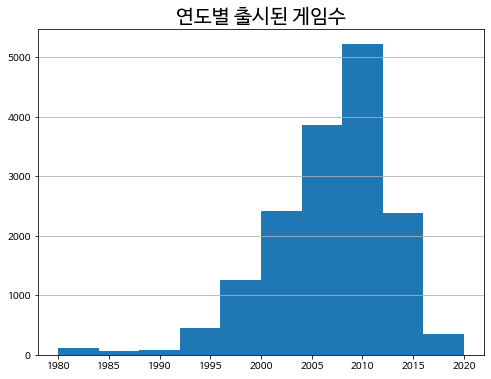

In [62]:
plt.figure(figsize = (8, 6))
plt.hist(df['Year'])
plt.title('Year histogram')
plt.grid(True,axis='y')
plt.xticks(fontsize = 10)
plt.title('연도별 출시된 게임수', fontsize = 20)
plt.show()

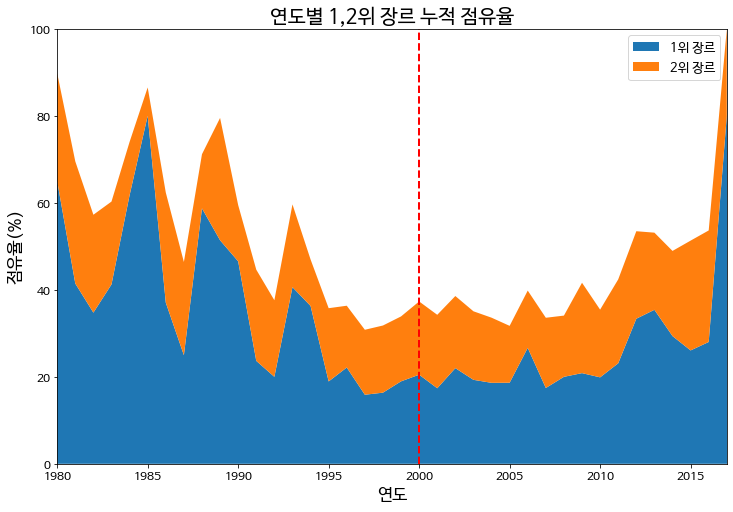

In [63]:
plt.figure(figsize = (12, 8))
plt.stackplot(Genre_merge_1['Year'], Genre_merge_1['share'], Genre_merge_2['share'], labels =  ['1위 장르', '2위 장르'])
plt.xlabel('연도', fontsize = 17)
plt.ylabel('점유율(%)', fontsize = 17)
plt.title('연도별 1,2위 장르 누적 점유율', fontsize =20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.axis([1980, 2017, 0, 100])
plt.axvline(2000, 0, 1, color='red', linestyle='--', linewidth=2)
plt.legend(fontsize = 13)
plt.show()

##### 시사점
연도별 1, 2위 장르 누적 점유율과 히스토그램을 종합해서 보면  <br>
2000년대에 들어서 많은 게임이 출시되었고 장르 점유율을 살펴보니 1,2위 장르의 점유율이 40%를 미치지 못하는 것을 볼 수 있다. 이는 특정 장르가 시장을 선점하지 않고 다양한 장르에서 게임이 출시되었음을 알 수 있다.
하지만 2017년 이후로 출시되는 게임의 수가 급격히 줄고있다. 이를 데이터의 불충분으로 생긴 현상일 수 있기 때문에 쏠림 현상인지 판단할 수 없음

In [64]:
Genre_merge_1.head()

,Year,Genre,total_x,total_y,share
0,1980,Shooter,7070000,10880000,64.98
1,1981,Action,14790000,35680000,41.45
2,1982,Puzzle,10040000,28880000,34.76
3,1983,Platform,6930000,16800000,41.25
4,1984,Shooter,31100000,50350000,61.77


In [65]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,total
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,40000,0,0,0,40000
1,The Munchables,Wii,2009,Action,Namco Bandai Games,170000,0,0,10000,180000
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0,0,20000,0,20000
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,40000,0,0,0,40000
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,120000,90000,0,40000,250000


In [66]:
ax[0,1].barh(EU['Genre'], EU['EU_Sales'], label = 'EU', color='#e35f62')
ax[0,1].set_xlabel('평균 판매량', fontsize = 15)
ax[0,1].set_title('유럽 장르별 평균 게임 판매량', fontsize =20)
ax[0,1].legend(fontsize = 10)


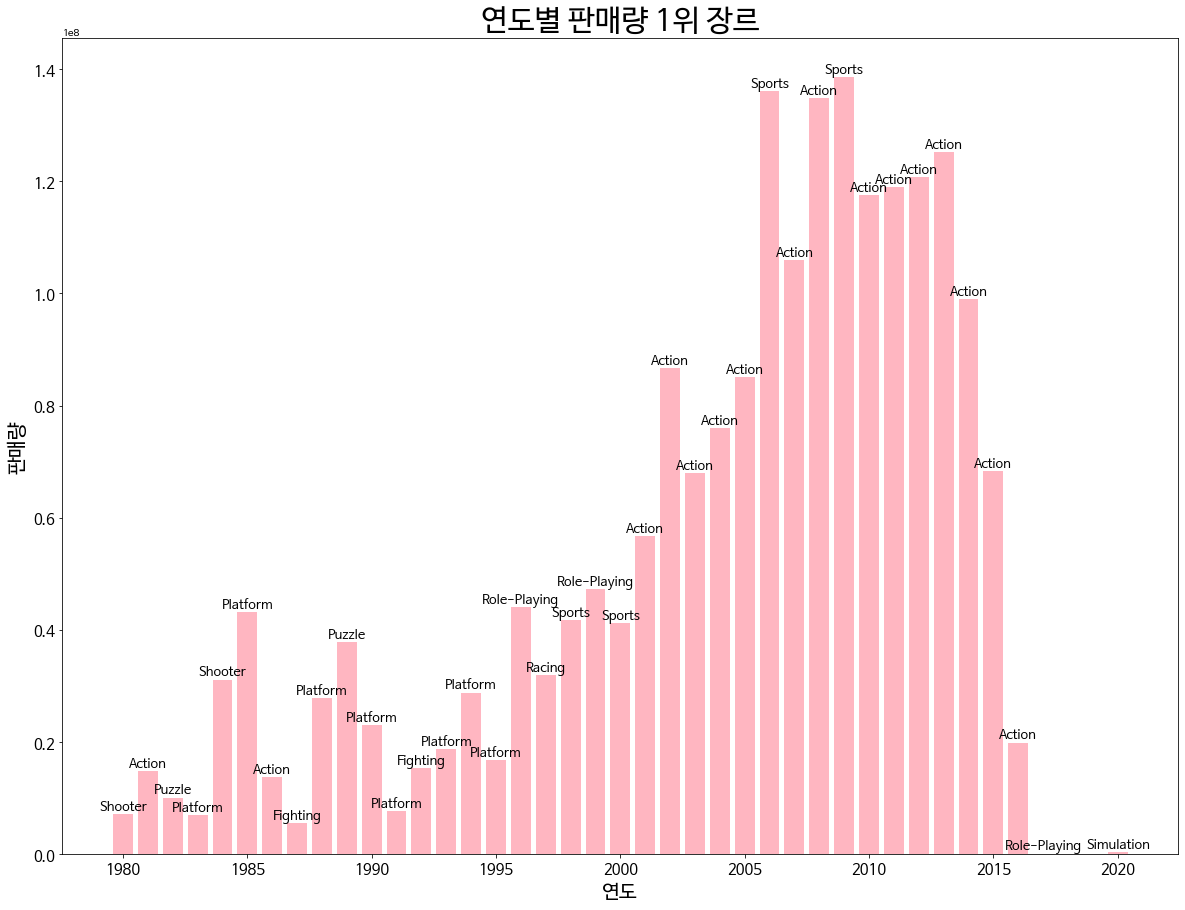

In [67]:
genre = Genre_merge_1['Genre']

plt.figure(figsize=(20, 15))
bar = plt.bar(Genre_merge_1['Year'], Genre_merge_1['total_x'], color = 'lightpink')


x= Genre_merge_1['Year']
y= Genre_merge_1['total_x']
z = Genre_merge_1['Genre']
# index = 0
# for value in Genre_merge_1['total_x']:
#     plt.text(index, value + 1, str(genre[index] + '-' +str(round(value, 2))), color='#000', size=20, rotation= 90, ha="center")
#     index += 1

for i, v in enumerate(x):
    plt.text(v, y[i], z[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 13, 
             color='black',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom',
             )    # verticalalignment (top, center, bottom)

plt.title("연도별 판매량 1위 장르", fontsize=30)
plt.xlabel("연도", fontsize=20)
plt.ylabel("판매량", fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
# plt.axis([1978, 2020, 5000000, 140000000])
plt.show()

2000년 전에는 shooter, action, platform 등 다양한 장르에 수요가 많았지만 <br>
판매량이 급증하는 2000년대부터 action 장르에 대한 선호가 집중되었다. <br>
sports 장르에 대한 수요가 급증했던 2006년은 독일월드컵의 영향으로 보인다.(외부요인)


####d. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스

1980년~2020년 전 시기 출고량

In [68]:
top_game = df.sort_values(by='total', ascending = False)
top_game = top_game.reset_index(drop=True).head(100)
top_game

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,total
0,Wii Sports,Wii,2006,Sports,Nintendo,41490000,29020000,3770000,8460000,82740000
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29080000,3580000,6810000,770000,40240000
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15850000,12880000,3790000,3310000,35830000
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15750000,11010000,3280000,2960000,33000000
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11270000,8890000,10220000,1000000,31380000
...,...,...,...,...,...,...,...,...,...,...
95,Super Smash Bros. for Wii U and 3DS,3DS,2014,Fighting,Nintendo,3240000,1350000,2420000,430000,7440000
96,Call of Duty: World at War,X360,2008,Shooter,Activision,4790000,1900000,0,690000,7380000
97,Battlefield 3,X360,2011,Shooter,Electronic Arts,4460000,2130000,60000,690000,7340000
98,The Legend of Zelda: Twilight Princess,Wii,2006,Action,Nintendo,3830000,2190000,600000,700000,7320000


In [69]:
top_game_p = top_game.groupby(['Platform'])['Name'].count().sort_values(ascending= False).reset_index()

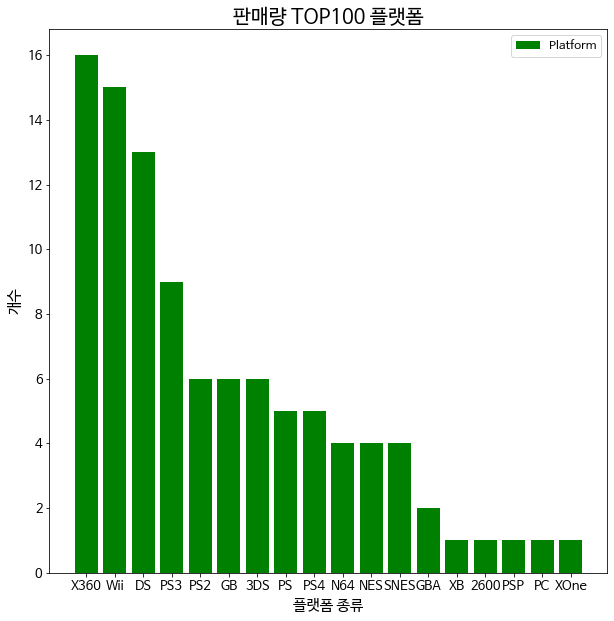

In [70]:
plt.figure(figsize = (10,10))
plt.bar( top_game_p['Platform'], top_game_p['Name'], label = 'Platform', color='green')
plt.xlabel('플랫폼 종류', fontsize = 15)
plt.ylabel('개수', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('판매량 TOP100 플랫폼', fontsize =20)
plt.legend(fontsize = 12)

In [71]:
top_game_g = top_game.groupby(['Genre'])['Name'].count().sort_values(ascending= False).reset_index()

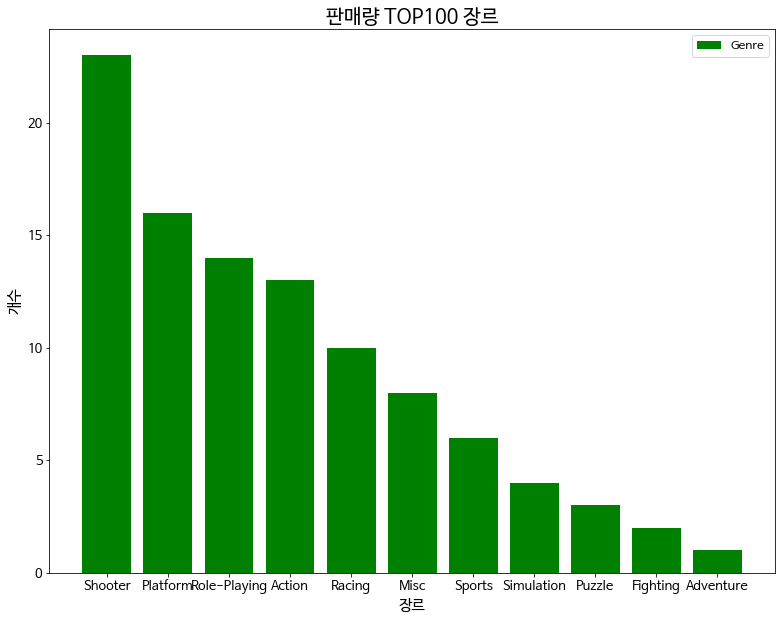

In [72]:
plt.figure(figsize = (13,10))
plt.bar( top_game_g['Genre'], top_game_g['Name'], label = 'Genre', color='green')
plt.xlabel('장르', fontsize = 15)
plt.ylabel('개수', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('판매량 TOP100 장르', fontsize =20)
plt.legend(fontsize = 12)

##### 시사점
판매량 기준으로 상위 100위 게임 장르를 분석했을 때 shooter 게임이 가장 많음을 알 수 있다. <br>
이전에서 본 그래프에서 action 장르가 2000년대 이후 압도적인 판매량이었음에도 4위를
 한 것으로 볼 때 <br>
shooter의 수요는 전 시기를 거쳐 꾸준히 이어진 것으로 파악된다. <br>


In [73]:
#마리오 시리즈 분석
x = top_game[top_game['Name'].str.contains('Mario')]
x.sort_values(by = 'Year')
x = x.reset_index(drop=True)

In [74]:
x.shape  #23개의 게임 

(23, 10)

In [75]:
x['Platform'].value_counts()  #7개의 플랫폼 

Wii     6
DS      4
NES     3
SNES    3
3DS     3
GB      2
N64     2
Name: Platform, dtype: int64

In [76]:
x['Genre'].value_counts()  #5가지 장르

Platform     14
Racing        5
Misc          2
Adventure     1
Sports        1
Name: Genre, dtype: int64

In [77]:
top_game[top_game['Name'].str.contains('Mario')]['total'].sum()

361849999

##결론

2008년 이후 비디오 게임 시장은 하락세를 보이고 있으며 앞으로도 시장 상황을 낙관하기 어려움 <br>
모바일 게임 시장의 규모가 커지는 시점에서 비디오 게임만의 경쟁력을 갖출 수 있는 전략 필요<br>
한 가지의 장르를 선택해야 한다면 꾸준한 점유율을 보이는 shooter를 선택하는 것이 적절하다고 판단 <br>
'수퍼마리오'가 40년간 높은 판매량을 기록할 수 있었던 것은 멀티 플랫폼과 장르의 다양화 때문 <br>
멀티 플랫폼 지원과 장르의 다양화를 염두하고 설계를 진행하는게 경쟁력이 높다고 봄  

